A practitioner’s guide for building LR systems using a data-driven approach
---



This notebook accompanies the paper "From data to a validated score-based LR system: a practitioner’s guide". The paper offers a guideline to go from a data set to a validated Likelihood Ratio (LR) system in 8 steps. In this notebook, we illustrate each of these steps with working Python code. In the code, we build and validate an LR system for a data set of observations on the elememental concentrations of glass fragments.

Follow along in the notebook by running the code blocks pressing Shift+Enter on your keyboard.

The guideline involves creating multiple LR systems at first, and selection of the best LR system in a later step. In this paper we explore two options to compute scores and two options to transform scores to LRs in a two-by-two design, leading to four LR systems.

The 'scorer' options are:
1. Use the Manhattan distance (defined as the sum of the absolute differences)
2. Use a support vector machine, a machine learning model

The 'calibrator' options to transform scores to LRs are:
<ol type = 'A'>
<li>Use a generative approach, namely kernel density estimation</li>
<li>Use a discriminative approach, namely logistic regression</li>
</ol>

### Loading Python packages

We start by installing several Python packages. These are standard packages, and the LiR package that we developed and maintain. This package provides a collection of scripts to aid construction and evaluation of LR systems.



In [1]:
# # Try to keep this in line with the requirements for lir itself
! pip install lir==1.2.0
! pip install scipy>=1.31
! pip install scikit-learn>=1.2
! pip install numpy>=1.22
# # Additional dependencies, already installed in Colab:
! pip install pandas seaborn==0.11.2

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [2]:
from itertools import combinations

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import paired_manhattan_distances
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import lir
from lir.algorithms.bayeserror import ELUBBounder
from lir.algorithms.kde import KDECalibrator
from lir.algorithms.logistic_regression import LogitCalibrator
from lir.plotting import show
from lir.transform.distance import AbsDiffTransformer
from lir.transform.pipeline import Pipeline


### Introduction LiR and sklearn


LiR follows the conventions of the sklearn package, which is the de facto standard in machine learning. This has the advantage that we can directly use all models defined in sklearn and that the code will look familiar to anyone used to sklearn. It has the disadvantage that naming of certain functions and objects may appear counterintuitive to those unfamiliar with sklearn. Sklearn defines objects that can 'fit' on data, and then 'transform' new data or 'predict' probabilities. LiR additionally allows to 'predict_lr'. We will encounter examples of these below.

### Loading the data

We download the glass data in the form of a csv file and convert this to a pandas dataframe.

In [3]:
csv_url = 'https://raw.githubusercontent.com/NetherlandsForensicInstitute/elemental_composition_glass/main/duplo.csv'
data_set = pd.read_csv(csv_url, delimiter=',').rename(
    columns = {'Item': 'Subject', 'Piece': 'Repeat', 'id': 'Id'})

# Step 1. Explore data




The data set we will use consists of elemental concentrations of float glass, obtained with LA-ICPMS (a type of mass spectrometer) ([see GitHub repository](https://github.com/NetherlandsForensicInstitute/elemental_composition_glass)). The elemental concentrations are on a log<sub>10</sub> basis, and normalized to the element silicon (Si). For each glass source, which we refer to as *subject*, two measurements are performed. Each time the concentration of ten elements is measured.

First, we will explore the type of data we have.

In [4]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       640 non-null    int64  
 1   Subject  640 non-null    int64  
 2   Repeat   640 non-null    int64  
 3   K39      640 non-null    float64
 4   Ti49     640 non-null    float64
 5   Mn55     640 non-null    float64
 6   Rb85     640 non-null    float64
 7   Sr88     640 non-null    float64
 8   Zr90     640 non-null    float64
 9   Ba137    640 non-null    float64
 10  La139    640 non-null    float64
 11  Ce140    640 non-null    float64
 12  Pb208    640 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 65.1 KB


As can be seen there are 13 columns for each observation:
- Id: a unique integer for each observation
- Subject: a unique integer for each subject
- Repeat: for each subject, a unique integer representing the repeated observations on this subject
- K39, Ti49, Mn55, Rb85, Sr88, Zr90, Ba137, La139, Ce140, Pb208: the processed concentration of the ten elements. The number behind the element in the column name specifies which isotope of the element was measured. The processed concentrations are all float numbers.

Furthermore, we see that there are no non-null values. In other words, there are no missing values.

Next, we have a look at the amount of data we have:

In [5]:
print('Number of observations: ', data_set['Id'].nunique())
print('Number of subjects: ', data_set['Subject'].nunique())
print('Maximum number of repeated observations on one subject: ',
      data_set['Repeat'].nunique())

Number of observations:  640
Number of subjects:  320
Maximum number of repeated observations on one subject:  2


Above you can see the number of glass panes (=distinct sources) and observations.

In this guide, we limit the number of items to ensure that we do not run out of RAM during the subsequent calculations.

In [6]:
# Make sure that the sorting is first by item, then by repeat
data_set = data_set.sort_values(by=['Subject', 'Repeat'], axis=0, ascending=True)

# Only keep the first 400 rows, as the free version of Google Colab does not
# have enough RAM available for computations on the full set
data_set = data_set.drop(data_set.index[400:])

As a check, the code block above can be run again, now showing 400 observations.

Each row of the dataframe contains one observation:


In [7]:
print(data_set.head())

   Id  Subject  Repeat       K39      Ti49      Mn55      Rb85      Sr88  \
0   1        1       1  2.632598  2.605259  2.256335  0.396947  1.792080   
1   2        1       2  2.650734  2.589055  2.302628  0.442676  1.767756   
2   3        2       1  2.961979  2.467961  2.182048  0.439477  1.710670   
3   4        2       2  2.945661  2.492296  2.179464  0.427490  1.757333   
4   5        3       1  2.960720  2.573878  2.071449  0.428202  1.717068   

       Zr90     Ba137     La139     Ce140     Pb208  
0  1.687005  1.636338  1.124591  1.518090  0.840343  
1  1.738677  1.615138  1.187096  1.516672  0.879644  
2  1.620326  1.626130  0.993176  1.338220  0.556401  
3  1.685472  1.616734  1.007451  1.290789  0.505195  
4  1.749157  1.808602  0.731249  1.000208  0.550739  




To get a bit more feeling for the data, we create a histogram of all observations per element together:


Histogram of all measured concentrations:


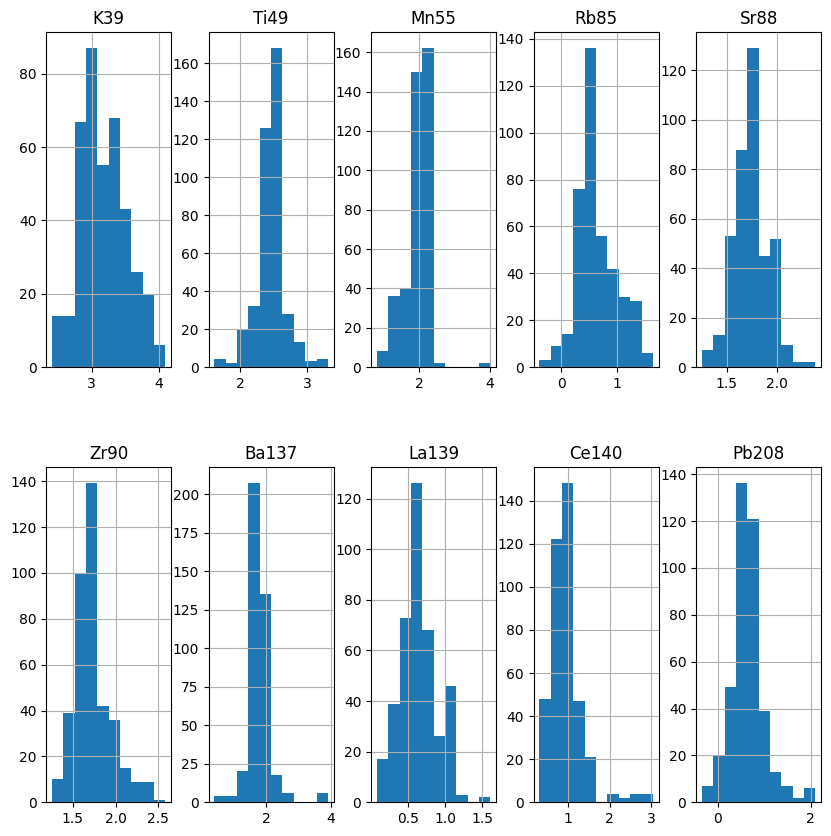

In [8]:
print('Histogram of all measured concentrations:')
data_set[['K39', 'Ti49', 'Mn55', 'Rb85', 'Sr88', 'Zr90', 'Ba137', 'La139',
          'Ce140', 'Pb208']].hist(figsize=(10,10), layout=(2,5));

In the histograms, we see that there are no distinctive outliers, although both Mn55 and Ba137 show data points with a relatively high value of around 4. As these is no reason to suspect an error, these probably reflect variability in the population and should not be removed.

Now, we select the variables (the 10 elements) and labels (indicating which subject was measured) and convert them to a numpy array. This is the format needed for the rest of the steps.

In [9]:
variables = ['K39', 'Ti49', 'Mn55', 'Rb85', 'Sr88', 'Zr90', 'Ba137', 'La139',
             'Ce140', 'Pb208']
labels = ['Subject']

obs = data_set[variables].to_numpy()
ids = data_set[labels].to_numpy()

### Explore data - a deeper look

Looking at the data more closely, we see that the concentrations for repeat measurements on the same subject are more similar to each other than the concentrations measured for different subjects. To examine this further, we calculate for each subject the standard deviation of its two measurements (a measure of within-source variability). We compare this to the standard deviation of the mean concentrations across all subjects (a measure of between-source variability). We expect the former to be smaller.

Histograms of standard deviations for the repeat measurements on a subject:


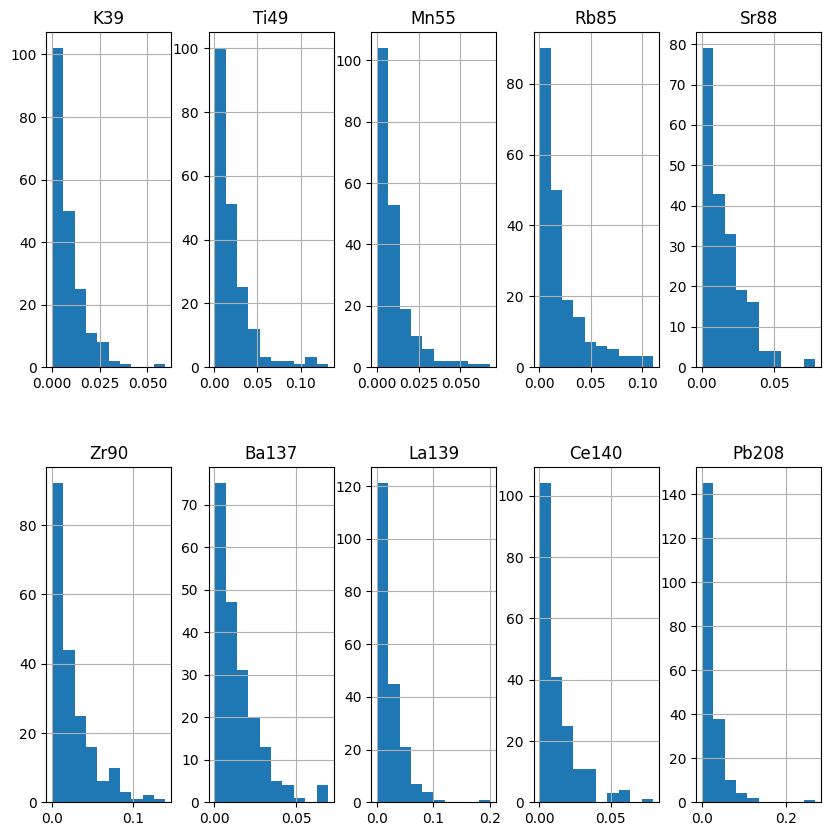

In [10]:
print('Histograms of standard deviations for the repeat measurements on a subject:')
data_set.groupby('Subject')[variables].std().hist(figsize=(10,10), layout=(2,5));

In [11]:
print('Between subject standard deviations compared to the maximum within subject standard deviation:')
st_devs = pd.DataFrame(data_set.groupby('Subject')[variables].mean().std())
st_devs.columns = ['std_between']
st_devs['std_within_mean'] = pd.DataFrame(
    data_set.groupby('Subject')[variables].std().mean())
st_devs['std_within_max'] = pd.DataFrame(
    data_set.groupby('Subject')[variables].std().max())
st_devs

Between subject standard deviations compared to the maximum within subject standard deviation:


,std_between,std_within_mean,std_within_max
K39,0.342577,0.008472,0.059352
Ti49,0.211560,0.019630,0.131448
Mn55,0.355806,0.009783,0.067969
Rb85,0.348709,0.020834,0.110103
Sr88,0.173895,0.015366,0.078621
Zr90,0.216477,0.024599,0.139017
Ba137,0.370425,0.013874,0.069095
La139,0.249051,0.022618,0.200405
Ce140,0.406627,0.012323,0.079508
Pb208,0.359028,0.022336,0.268438


We see that the within-source standard deviations roughly lie between 0 and 0.03 (second column), and between-source standard deviations are much larger (first column). This holds for all elements. In fact, the between objects standard deviation is larger than the largest within standard deviation we encounter (third column). This indicates that an LR system based on this data can be discriminative.

When different variables are considered for calculating an evidential value, it is best when these variables have a correlation coefficient close to zero. If two variables are highly correlated however, they can still both be used in the LR system; their combined within variance is reduced compared to measuring a single variable. If the number of variables is large compared to the number of subjects, we may consider dimension reduction.

To see to what extent the concentrations of the different elements are correlated, we create scatterplots plotting the concentrations against each other.

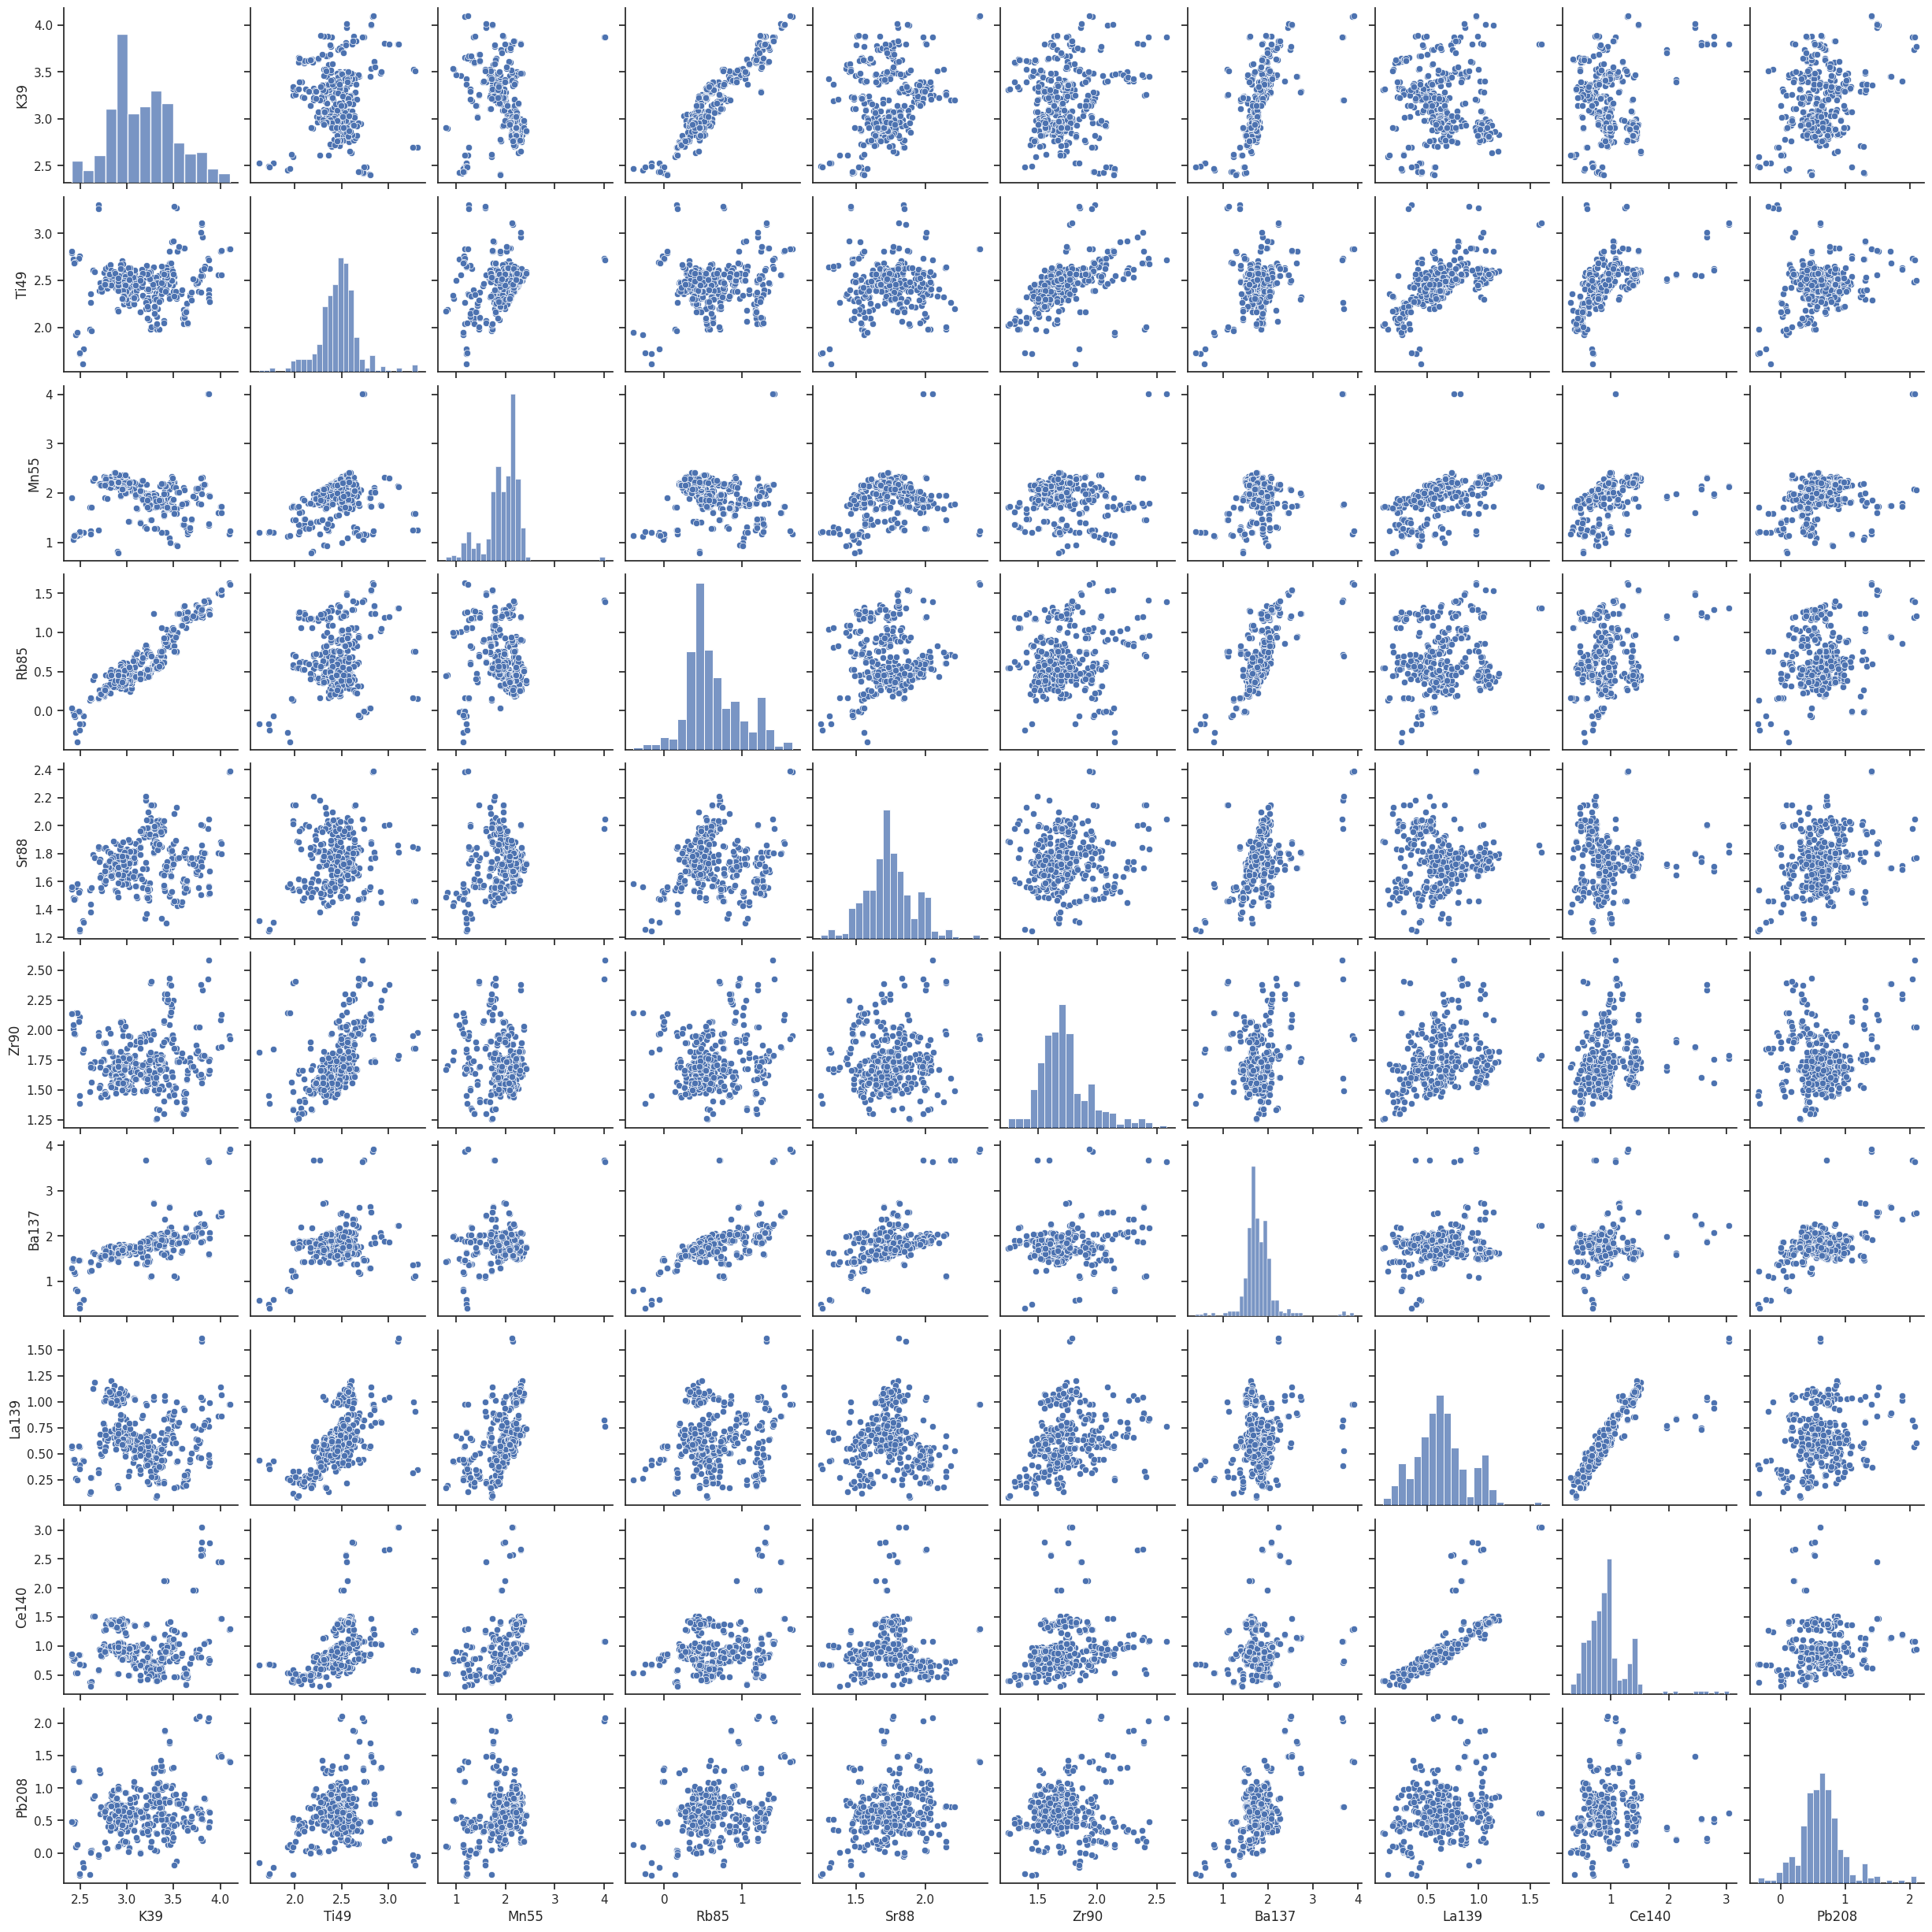

In [12]:
sns.set_theme(style='ticks')
sns.pairplot(data_set.reset_index()[variables])
plt.show()
plt.close()

We see that some of the values are correlated, for example for K39 and Rb85. Most scatterplots seem quite random, indicating a low correlation. This is indeed reflected in the correlation matrix:

In [13]:
corr = data_set[variables].corr()
corr.style.background_gradient()

,K39,Ti49,Mn55,Rb85,Sr88,Zr90,Ba137,La139,Ce140,Pb208
K39,1.000000,0.067055,-0.127568,0.935838,0.252946,0.098428,0.653097,-0.071568,0.138057,0.247101
Ti49,0.067055,1.000000,0.267245,0.155035,0.102537,0.503558,0.224503,0.610159,0.523428,0.229031
Mn55,-0.127568,0.267245,1.000000,-0.065061,0.184014,-0.039307,0.148426,0.511505,0.356001,0.286841
Rb85,0.935838,0.155035,-0.065061,1.000000,0.097745,0.131032,0.648316,0.116004,0.274328,0.268985
Sr88,0.252946,0.102537,0.184014,0.097745,1.000000,0.067813,0.518871,-0.030820,-0.043135,0.246441
Zr90,0.098428,0.503558,-0.039307,0.131032,0.067813,1.000000,0.189331,0.292032,0.232167,0.154067
Ba137,0.653097,0.224503,0.148426,0.648316,0.518871,0.189331,1.000000,0.106475,0.131475,0.548194
La139,-0.071568,0.610159,0.511505,0.116004,-0.030820,0.292032,0.106475,1.000000,0.807132,0.203315
Ce140,0.138057,0.523428,0.356001,0.274328,-0.043135,0.232167,0.131475,0.807132,1.000000,0.112706
Pb208,0.247101,0.229031,0.286841,0.268985,0.246441,0.154067,0.548194,0.203315,0.112706,1.000000


As the level of correlation is not too high, in this notebook we proceed with these data as they are. However, given that some variables are (strongly) correlated, we encourage the reader to experiment with improving the resulting LR system by handling this correlation. For example, by combining these variables or removing some from our data set (a form of dimensionality reduction), or utilizing models that allow for high correlation between variables.

# Step 2. Split data in different subsets


As explained in the manuscript, splitting the data is a necessary step in order to evaluate the performance of the model while avoiding overfitting. This means that part of the data will be used to build the model (training and selection sets) and another part is reserved for validation.

As shown in the steps below, all three sets should be independent, e.g. consist of disjoint sets of glass objects. First, we set 20% of the objects aside for the validation set, and then we split the remaining objects into a training (80%) and a selection (20%) set.

```
Total: 400
        / \
      320  80 (validation)
      / \
    256  64
 (train) (test)
```

In [ ]:
# FeatureData

from lir.data.models import FeatureData

# First we split off 20% from the data as a hold-out validation set (grouped per glass fragment)
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state=1)
split = splitter.split(obs, groups=ids)  # train (80%), test (20%)

test_train_indices, validation_indices = next(split)

# Then we split off 20% to use as a test set from the remaining 80%
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state=1)
split = splitter.split(obs[test_train_indices], groups=ids[test_train_indices])
train_indices, test_indices = next(split)

# We create the train, test (or 'selection') and validation set
train = FeatureData(features=obs[train_indices], labels=ids[train_indices].flatten())
test = FeatureData(features=obs[test_indices], labels=ids[test_indices].flatten())
validation = FeatureData(features=obs[validation_indices], labels=ids[validation_indices].flatten())


# Show the sizes of the data sets
print(f'Size of total data set:  {len(obs):<4} (100%)')
print(f'Size of training set:    {len(train):<4} (64% (80% of 80%))')
print(f'Size of test set:        {len(test):<4} (16% (20% of 80%))')
print(f'Size of validation set:  {len(validation):<4} (20%)')

Size of total data set:  400  (100%)
Size of training set:    256  (64% (80% of 80%))
Size of test set:        64   (16% (20% of 80%))
Size of validation set:  80   (20%)


# Step 3. Pre-process data

This step entails transformation of the raw data to informative features that can be used by a statistical model. Standard transformations for concentration data are taking the log<sub>10</sub> and normalising by a certain variable (in this particular example: dividing all other variables by the value of Si), both of which are already applied per observation to the glass data we use.

To show another example of preprocessing, in addition we here apply a z-score transformation per column to the data set: subtracting the mean and dividing by the standard deviation.

In [ ]:
from lir.transform import NumpyTransformer

print('The first row of observations\n')
print(f'   - before transformation: \n{obs[0, :]}\n')

# TODO - To pass the `FeatureData` of `train` to the `z_score_transformer`, we need to wrap the
# `StandardScaler` class from scikitlearn within a class that *does* support these `FeatureData`
# instances. 
# At this stage, we don't know how to circumvent the issue, as `NumpyTransformer` seems to delegate
# to the `self.wrapped_transformer` class - which is `StandardScaler` in this case.
z_score_transformer = NumpyTransformer(transformer=StandardScaler(), header=None)

z_score_transformer.fit(train)

obs_zscore = z_score_transformer.transform(obs)

print(f'    - after transformation: \n{obs_zscore[0, :]}')

The first row of observations

   - before transformation: 
[2.6325985  2.60525854 2.25633478 0.39694682 1.79207969 1.68700486
 1.63633785 1.12459117 1.51809019 0.84034307]



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 2) + inhomogeneous part.

We can see what this transformation does for one of the columns, that of the element K39, in the figure below. The distribution is scaled and shifted, but otherwise the same. In a plot, this manifests itself as adjusted x-values:

In [ ]:
plt.hist(obs[:, 0], bins=20, histtype='step', color='tab:purple', alpha=1, label='before pre-processing')
plt.hist(obs_zscore[:, 0], bins=20, color='tab:cyan', alpha=0.5, label='after pre-processing')
plt.xlabel('K39 value')
plt.ylabel('count')
plt.legend()

# Step 4. Calculate scores

In the previous steps, we have explored the given data, split it into subsets and performed pre-processing. We call the 10 pre-processed values we now have for each observation the features. The next step is to go from these feature vectors to a score. In order to do this we have to make pairs of observations, both *H*<sub>1</sub>-true and *H*<sub>2</sub>-true, and calculate the scores based on their feature vectors. A score is meant to quantify the degree of (dis)similarity between a pair of observations.


### Create pairs

The function `create_pairs` below creates one *H*<sub>1</sub>-true pair per subject, and one *H*<sub>2</sub>-true pair for each pair of different subjects.

In [ ]:
def create_pairs(obs, ids):
    """
    Creates all possible pairs between the items represented by ids.
    The ids refer to the total set of observations given by obs.
    """
    # Create matrices with item IDs that refer to the total data set
    H1_ids = np.transpose(np.tile(np.unique(ids), (2, 1)))
    H2_ids = np.asarray(list(combinations(np.unique(ids), 2)))

    # For H1-data: use the first repeat for each item in the first column,
    # and the second repeat of that item in the second.
    # We assume: that obs is sorted first by item ID, then by repeat ID;
    # that all items have exactly 2 repeats; that there are no missing items.
    H1_obs_rep_1 = obs[2*H1_ids[:,0] - 2]
    H1_obs_rep_2 = obs[2*H1_ids[:,1] - 1]
    H1_obs_pairs = np.stack((H1_obs_rep_1, H1_obs_rep_2), axis=2)

    # For H2-data: use for both items their first repeats
    H2_obs_item_1 = obs[2*H2_ids[:,0] - 2]
    H2_obs_item_2 = obs[2*H2_ids[:,1] - 2]
    H2_obs_pairs = np.stack((H2_obs_item_1, H2_obs_item_2), axis=2)

    # Combine the H1 and H2 data, and create vector with two classes: H1 and H2
    obs_pairs = np.concatenate((H1_obs_pairs, H2_obs_pairs))
    hypothesis = np.concatenate((np.array(['H1']*len(H1_ids)),
                            np.array(['H2']*len(H2_ids))))

    return obs_pairs, hypothesis

We create the pairs for the subjects in the training data and the selection data.

In [ ]:
obs_pairs_train, hypothesis_train = create_pairs(obs_zscore, ids_train)
obs_pairs_select, hypothesis_select = create_pairs(obs_zscore, ids_select)

print(f'We have constructed {len(obs_pairs_train)} pairs in the training data, \
{int(sum(hypothesis_train=='H1'))} H1 and {int(sum(hypothesis_train=='H2'))} H2 pairs.')
print(f'For the selection data we have {len(obs_pairs_select)} pairs, \
{int(sum(hypothesis_select=='H1'))} H1 and {int(sum(hypothesis_select=='H2'))} H2 pairs.\n')

print('Looking at the values for the first pair, \n')
print(obs_pairs_train[0,:,:])
print('\nwe see this is just the concatenation of the feature vectors of the \
two observations on the first subject:\n')
print(obs_zscore[:2,:])

Once we have the same-source and different-source pairs we have to compute the score per pair. We show two different ways.

### Option A: Compute (dis)similarity score
We take the Manhattan distance. The Manhattan distance is the sum of the absolute differences of the features. Luckily, distances such as these are standard functions in the python package sklearn.

In [ ]:
dissimilarity_scores_train = paired_manhattan_distances(obs_pairs_train[:,:,0], obs_pairs_train[:,:,1])
dissimilarity_scores_select = paired_manhattan_distances(obs_pairs_select[:,:,0], obs_pairs_select[:,:,1])

print('For the same first pair (H1 is true) shown above, we get the following features: \n')
print(obs_pairs_train[0,:,:])

print('\nWe calculate the absolute differences per feature:\n')
print(np.absolute(np.diff(obs_pairs_train[0,:,:], axis = 1)))
print('\nWhen summed, we get a relatively low absolute difference of\n')
print(dissimilarity_scores_train[0])

print('\n\nIf we do the same for the first H2-true pair, \n')
print(obs_pairs_train[hypothesis_train=='H2',:,:][0])
print('\nwe get a much higher distance of\n')
print(dissimilarity_scores_train[hypothesis_train=='H2'][0])

More generally, we see that *H*<sub>2</sub>-true pairs get higher dissimilarity scores, as expected:

In [ ]:
with show() as ax:
    ax.score_distribution(scores=dissimilarity_scores_train, y=(hypothesis_train=='H1')*1,
                          bins=np.linspace(0, 30, 60), weighted=True)
    plt.xlabel('dissimilarity score')
    H1_legend = mpatches.Patch(color='tab:blue', alpha=.3, label='$H_1$-true')
    H2_legend = mpatches.Patch(color='tab:orange', alpha=.3, label='$H_2$-true')
    ax.legend(handles=[H1_legend, H2_legend])

### Option B: Compute machine learning score
Alternatively, we can fit a statistical model to compute scores. In this case, we use a support vector machine. First, the absolute differences for each elemental value between the pairs of observations are computed. The support vector machine then assigns a score to each pair. The model aims to assign high scores to *H*<sub>1</sub>-true pairs and low scores to *H*<sub>2</sub>-true pairs.

In [ ]:
# Machine learning models need a single vector as input. The AbsDiffTransformer takes two feature vectors,
# one for each subject of a pair, and returns the elementwise absolute differences.
# The AbsDiffTransformer and support vector machine (SVC) are combined into a single pipeline using sklearns Pipeline class.
machine_learning_scorer = Pipeline([('abs_difference', AbsDiffTransformer()), ('classifier', SVC(probability=True))])

# The model has to be fit on the data
machine_learning_scorer.fit(obs_pairs_train, hypothesis_train=='H1')
# Scores can be computed using the 'predict_proba' function. This is another sklearn convention,
# which returns two columns of which we take the second using '[:,1]'
machine_learning_scores_train = machine_learning_scorer.predict_proba(obs_pairs_train)[:, 1]

The scores look like this:

In [ ]:
with show() as ax:
    ax.score_distribution(scores=machine_learning_scores_train, y=(hypothesis_train=='H1')*1,
                          bins=np.linspace(0, 1, 10), weighted=True)
    plt.xlabel('machine learning score')
    H1_legend = mpatches.Patch(color='tab:blue', alpha=.3, label='$H_1$-true')
    H2_legend = mpatches.Patch(color='tab:orange', alpha=.3, label='$H_2$-true')
    ax.legend(handles=[H1_legend, H2_legend])

In [ ]:
print(f'For example, the machine learning score for the H1-true pair from option A is \
{round(machine_learning_scores_train[hypothesis_train=='H1'][0],8)}, and for \
the first H2-true pair {round(machine_learning_scores_train[hypothesis_train=='H2'][0],8)}. ')

As expected, the *H*<sub>1</sub>-true pairs generally have lower dissimilarity scores than the *H*<sub>2</sub>-true pairs, while their machine learning scores are higher.

# Step 5. Calculate LRs from scores

After step 4 we have a score for each pair. Two approaches exist to convert these scores to LRs. We show an example for each approach.



### Generative approach

In the generative approach, we model the distribution of scores under *H*<sub>1</sub> and under *H*<sub>2</sub>. Here, we use kernel density estimation (KDE) to do this. KDE is a way to estimate an unknown probability density by 'smoothing' the observed distribution. LiR defines classes called 'Calibrators' to perform the score to LR mapping.

In [ ]:
kde_calibrator = KDECalibrator(bandwidth='silverman')

To illustrate how this works, we plot the histograms for the scores under *H*<sub>1</sub> and *H*<sub>2</sub>-true, together with the KDE fits.


In [ ]:
kde_calibrator.fit(dissimilarity_scores_train, hypothesis_train=='H1')
with show() as ax:
    ax.calibrator_fit(kde_calibrator, score_range=[0,30])

In [ ]:
kde_calibrator.fit(dissimilarity_scores_train, hypothesis_train=='H1')
with show() as ax:
    ax.calibrator_fit(kde_calibrator, score_range=[0, 30])
    ax.score_distribution(scores=dissimilarity_scores_train, y=(hypothesis_train=='H1')*1,
                          bins=np.linspace(0, 30, 60), weighted=True)
    ax.xlabel('dissimilarity score')
    H1_legend = mpatches.Patch(color='tab:blue', alpha=.3, label='$H_1$-true')
    H2_legend = mpatches.Patch(color='tab:orange', alpha=.3, label='$H_2$-true')
    ax.legend(handles=[H1_legend, H2_legend])

### Discriminative approach
Alternatively, we can use other discriminative methods. Here we use logistic regression to map the score to posterior odds. This can be corrected for the amount of *H*<sub>1</sub> and *H*<sub>2</sub> data.

In [ ]:
logreg_calibrator = LogitCalibrator()

### Bounding the LRs

The LR system may output values that seem too large or too small given the size of our data set. Several methods have been proposed mitigate this problem, by 'shrinking' the LRs towards 1. Here we show how to use empirical lower and upper bounds (ELUB) to limit the minimum and maximum values the LR system can output. Using LiR, we can stack this 'ELUBbounder' on any calibrator we have.

In [ ]:
bounded_kde_calibrator = ELUBBounder(kde_calibrator)
bounded_logreg_calibrator = ELUBBounder(logreg_calibrator)

### Illustration of scores to LRs
To illustrate the score to LR mapping, we plot how the dissimilarity scores are mapped to LRs (using a log<sub>10</sub> scale). We print the values of the ELUB bounds - these are visible in the plot as the minimum and maximum values the LRs obtain (horizontal lines).

One thing to note is that the purple (logistic regression) never goes up. This is a desirable property, it makes sense that more extreme scores correspond to more extreme LRs. In contrast, the cyan line (kernel density estimation (KDE)) shows several humps, e.g. at score=0 and score=2. This means that, counterintuitively, sometimes a higher dissimilarity leads to a lower LR. Here we don't 'fix' this (e.g. by adjusting the bandwidth of the KDE), but be aware that some methods for transforming scores to LRs can have this property.

In [ ]:
lrs_train_logreg = bounded_logreg_calibrator.fit_transform(dissimilarity_scores_train, hypothesis_train=='H1')
lrs_train_kde = bounded_kde_calibrator.fit_transform(dissimilarity_scores_train, hypothesis_train=='H1')

plt.scatter(dissimilarity_scores_train, lrs_train_logreg, color='tab:purple', marker='.', label='logistic regression')
plt.scatter(dissimilarity_scores_train, lrs_train_kde, color='tab:cyan', label = 'KDE')
plt.xlim([0, 5])

plt.legend()

plt.xlabel('dissimilarity score')
plt.ylabel('log$_{10}$(LR)')

print(f'ELUB log(LR) bounds for logistic reggression are {(bounded_logreg_calibrator.lower_llr_bound):.2f} and \
{(bounded_logreg_calibrator.upper_llr_bound):.2f}')
print(f'ELUB log(LR) bounds for KDE are {(bounded_kde_calibrator.lower_llr_bound):.2f} and \
{(bounded_kde_calibrator.upper_llr_bound):.2f}')

Note that for the generative approach, the score to LR function is not monotonous. This is something we do not expect from a score to LR function, and possibly could be solved by using a kernel density estimator with a greater bandwidth.

# Step 6. Select best LR system



In this step, we compute the performance of each LR system defined on the selection data. For this, we use the CalibratedScorer class from LiR, which allows you to combine computing scores and transforming to LRs in one step. A CalibratedScorer needs two parts: a function or machine learning model to compute scores, and a Calibrator to transform the scores to LRs.

We define a function to give us the histograms of the LRs, the PAV plot, the ELUB bounds and the *C*<sub>llr</sub>:

In [ ]:
def show_performance(lrs, hypothesis, calibrator):
    hypothesis=(hypothesis=='H1')*1 # Convert to 0 or 1 for technical reasons

    # Show the distribution of LRs together with the ELUB values
    print('Histogram of the LRs:\n')

    with show() as ax:
        ax.lr_histogram(lrs, hypothesis)
        H1_legend = mpatches.Patch(color='tab:blue', alpha=.25, label='$H_1$-true')
        H2_legend = mpatches.Patch(color='tab:orange', alpha=.25, label='$H_2$-true')
        ax.legend(handles=[H1_legend, H2_legend])

    print(f'\nELUB log(LR) bounds are {np.log10(calibrator._lower_lr_bound):.2f} and\
    {np.log10(calibrator._upper_lr_bound):.2f} \n')

    print('PAV plot (closer to the line y=x is better):\n')
    # Show the PAV plot (closer to the line y=x is better)
    with show() as ax:
        ax.pav(lrs, hypothesis)

    # Print the quality of the system as log likelihood ratio cost (lower is better)
    print(f'\n The log likelihood ratio cost is {lir.metrics.cllr(lrs, hypothesis):.3f} (lower is better)\n')

### Option 1: Manhattan distance + KDE



In [ ]:
# We define the CalibratedScorer. We use the standard sklearn function
# paired_manhattan_distance to compute the scores, and an ELUB bounded
# KDE calibrator to transform to LRs.
lr_system = lir.CalibratedScorer(paired_manhattan_distances, bounded_kde_calibrator)
# We fit the entire LR system
lr_system.fit(obs_pairs_train, hypothesis_train=='H1')

# We compute the LRs on the selection data
lrs_select = lr_system.predict_lr(obs_pairs_select)

# This is how well the system performs
show_performance(lrs_select, hypothesis_select, lr_system.calibrator)

### Option 2: Manhattan distance + logistic regression

In [ ]:
# We define the CalibratedScorer. We use the standard sklearn function paired_manhattan_distance to compute the scores,
# and an ELUB bounded logistic regression calibrator to transform to LRs.
lr_system = lir.CalibratedScorer(paired_manhattan_distances, bounded_logreg_calibrator)
# We fit the entire LR system
lr_system.fit(obs_pairs_train, hypothesis_train=='H1')

# We compute the LRs on the selection data
lrs_select = lr_system.predict_lr(obs_pairs_select)

# This is how well the system performs
show_performance(lrs_select, hypothesis_select, lr_system.calibrator)

### Option 3: support vector machine + KDE



In [ ]:
# The whole LR system consists of computing the score and then mapping the scores to LRs.
# We use the machine learning scorer introduced in step 4
scorer = Pipeline([('abs_difference', AbsDiffTransformer()), ('classifier', SVC(probability=True))])

lr_system = lir.CalibratedScorer(scorer, bounded_kde_calibrator)

# We fit the whole system. When fitting (=training) a CalibratedScorer, both the
# machine learning model and the transformation to LRs are trained on the supplied data
lr_system.fit(obs_pairs_train, hypothesis_train=='H1')
lrs_select = lr_system.predict_lr(obs_pairs_select)

show_performance(lrs_select, hypothesis_select, lr_system.calibrator)

### Option 4: support vector machine + logistic regression


In [ ]:
# The whole LR system consists of computing the score and then mapping the scores to LRs
scorer = Pipeline([('abs_difference', AbsDiffTransformer()), ('classifier', SVC(probability=True))])

lr_system = lir.CalibratedScorer(scorer, bounded_logreg_calibrator)
# We fit the whole system
lr_system.fit(obs_pairs_train, hypothesis_train=='H1')
lrs_select = lr_system.predict_lr(obs_pairs_select)

show_performance(lrs_select, hypothesis_select, lr_system.calibrator)

### Final selection
All four options show reasonable LR distributions. Because the glass data contain much information, the *H*<sub>1</sub> and *H*<sub>2</sub> are almost perfectly separated. Most of the *H*<sub>2</sub> pairs, and many of the *H*<sub>1</sub> pairs fall on the ELUB bounds. We see similar performance across the four systems. The LR distributions look reasonable for all systems, the PAV plots look good for options 2 and 3 (with the points following the line y=x) and show slightly conservative LRs for options 1 and 4 (points lying above the line y=x).

We have a slight preference for option 3, which has a good PAV plot, the best (=lowest) *C*<sub>llr</sub> and best (=widest) ELUB bounds. Option 2 would also have been a reasonable choice, particularly as the Manhattan distance is much more explainable than the support vector machine.

# Step 7. Validate selected LR system


After selecting the (best) model, you should assess the performance of the system on the validation set.

### Construct the selected system

Since we want to build the selected model based on as much data as possible, we add the selection set to the training set and use the combination to train the LR system used for validation.

In [ ]:
# Create the combined data set
obs_train_select = obs[train_select_indices]
ids_train_select = ids[train_select_indices]

# Step 3 pre-processing: normalise
z_score_transformer.fit(obs_train_select)
obs_zscore = z_score_transformer.transform(obs)

# Step 4: combine the pairs into one feature vector by taking the absolute difference
obs_pairs_train_select, hypothesis_train_select = create_pairs(obs_zscore, ids_train_select)
obs_pairs_val, hypothesis_val = create_pairs(obs_zscore, ids_val)

selected_lr_system = lir.CalibratedScorer(machine_learning_scorer,
                                          lir.ELUBbounder(lir.KDECalibrator(bandwidth='silverman')))
# Step 4+5 combined: we fit the whole system
selected_lr_system.fit(obs_pairs_train_select, hypothesis_train_select=='H1')

# Compute the LRs on the validation data
lrs_val = selected_lr_system.predict_lr(obs_pairs_val)

### Calculate system performance

In [ ]:
# We always inspect the characteristics we also look at in selection
show_performance(lrs_val, hypothesis_val, selected_lr_system.calibrator)

In [ ]:
# There are many other characteristics that we may want to inspect,
# such as the empirical cross entropy (ECE) plot
with show() as ax:
      ax.ece(lrs_val, hypothesis_val=='H1')

In the validation, we hope to see performance comparable to that on the selection data. This is the case here, with *C*<sub>llr</sub>, ELUB bounds and LR distributions looking very similar to those we saw in step 6. The PAV plot looks reasonable, with the data points mostly following the line y=x. There are a few datapoints that lie under this line, indicating a slight overconfidence of the system in this LR range. The ECE plot in Figure shows that the LRs are, for any prior odds, performing substantially better than a system where LR=1 (the reference system).

# Step 8. Construct casework LR system


To obtain our casework LR system, we fit on all available data:

In [ ]:
# Create new pairs for the combined data
obs_zscore = z_score_transformer.fit_transform(obs)
obs_pairs, hypothesis = create_pairs(obs_zscore, ids)

# Fit the same system on all the data
selected_lr_system.fit(obs_pairs, hypothesis=='H1');

Note that we cannot empirically test this system. In casework, if you have decided to use the system, you would input your pair of observation and get back an LR.

In [ ]:
observation_1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
observation_2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

manually_entered_data = np.moveaxis(np.array([z_score_transformer.transform([observation_1,observation_2])]),1,-1)

print(f'The LR obtained is {selected_lr_system.predict_lr(manually_entered_data)[0]}')